# Radiosensitivity prediction with Logistic Regression

In [1]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


In [2]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [3]:
def evaluation(clf, X, y):
    
    y_pred = clf.predict(X)
    y_pred_proba = clf.decision_function(X)

    fp_rates, tp_rates, _ = roc_curve(y, y_pred_proba)
    #ax.plot(fp_rates, tp_rates, label = str(fold))
    roc_auc = auc(fp_rates, tp_rates)

    accuracy  = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall    = recall_score(y, y_pred)
    f1        = f1_score(y, y_pred)
    roc_auc   = auc(fp_rates, tp_rates)
    confusion = confusion_matrix(y, y_pred)

    return [accuracy, precision, recall, f1, roc_auc, fp_rates, tp_rates, confusion]

## Preprocessing

In [4]:
sample_info = pd.read_csv('../data/sample_info.csv')
radiosensitivity = pd.read_csv('../data/radiosensitivity.csv')
expression = pd.read_csv('../data/expressionData.csv')

### Assigning classes to the label

In [5]:
sc = StandardScaler()
radiosensitivity['sf2_scaled'] = sc.fit_transform(np.asarray(radiosensitivity['SF2']).reshape(-1,1))

std = radiosensitivity['sf2_scaled'].std()
mean = radiosensitivity['sf2_scaled'].mean()

for i in range(radiosensitivity.shape[0]):
    if radiosensitivity.at[i, 'sf2_scaled'] < mean - std * 0.8:
        radiosensitivity.at[i, 'Sensitivity'] = 'sensitive'
    elif radiosensitivity.at[i, 'sf2_scaled'] > mean + std * 0.8:
        radiosensitivity.at[i, 'Sensitivity'] = 'resistant'
    else:
        radiosensitivity.at[i, 'Sensitivity'] = 'intermediate'

data = pd.merge(radiosensitivity[['cell_line_name', 'Sensitivity']], expression, on='cell_line_name', how='inner')
data = pd.merge(data, sample_info[['cell_line_name', 'lineage']], left_on='cell_line_name', right_on='cell_line_name', how='inner')

In [6]:
data['Sensitivity'] = data['Sensitivity'].replace({'sensitive': 1, 'resistant': 0, 'intermediate': 2})
data = data.drop(data[data.Sensitivity == 2].index)
data.drop(columns=['cell_line_name'], inplace=True)

/scratch/tmp.32618.fschindele/ipykernel_2501355/3187357292.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sensitivity'] = data['Sensitivity'].replace({'sensitive': 1, 'resistant': 0, 'intermediate': 2})


In [7]:
y = data['Sensitivity']
X = data.drop(columns=['Sensitivity'])

In [8]:
cat_cols = ['lineage']
num_cols = X.loc[:, X.dtypes == 'float64'].columns.values
lineage = pd.DataFrame(X['lineage'])
lineage = pd.get_dummies(lineage, columns=cat_cols, drop_first=True, dtype=int)

## ML models

### LR, PCA + lineage, 10-fold CV

### LR, PCA + lineage, 5-fold CV

### LR, PCA, 5-fold CV

In [9]:
X.drop(columns=['lineage'], inplace=True)

Working on fold 1
Train: 
[[60 20]
 [21 50]]
Test: 
[[16  4]
 [ 6 12]]
Working on fold 2


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train: 
[[63 17]
 [23 48]]
Test: 
[[13  7]
 [ 7 11]]
Working on fold 3
Train: 
[[63 17]
 [21 50]]
Test: 
[[12  8]
 [ 5 13]]
Working on fold 4
Train: 
[[70 10]
 [14 57]]
Test: 
[[14  6]
 [ 9  9]]
Working on fold 5
Train: 
[[65 15]
 [27 45]]
Test: 
[[14  6]
 [ 3 14]]


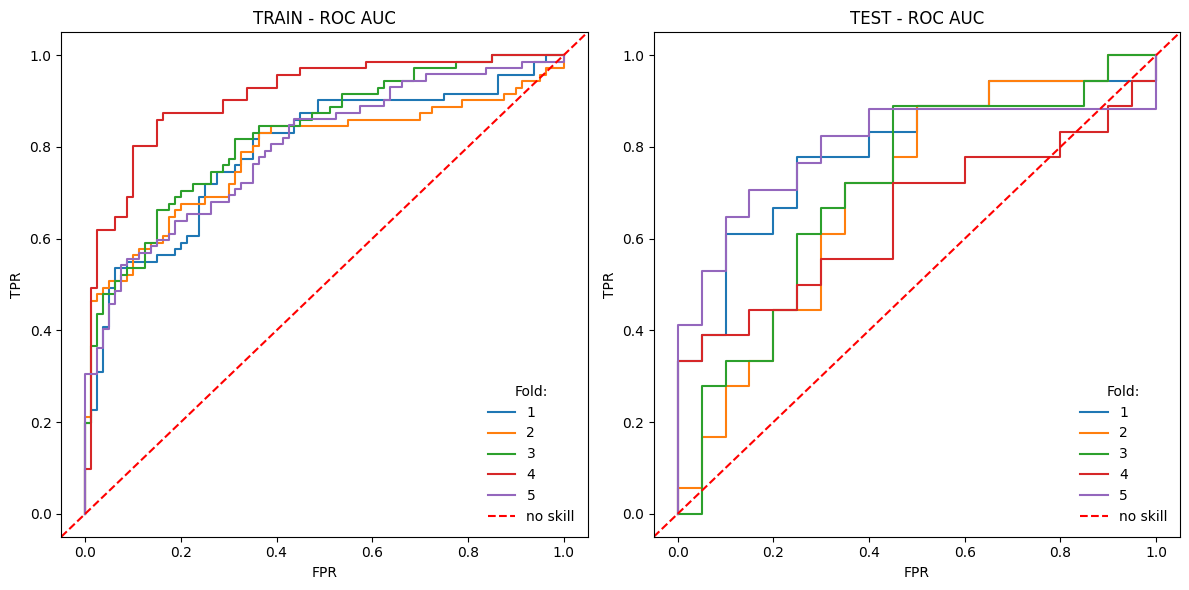

In [10]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=0)
fold = 1

train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
best_params = {'pca__n_components': [],
               'logistic__C': []}

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))

param_grid = {'pca__n_components': np.linspace(5, 40, 10, dtype=int),
              'logistic__C': 10**np.linspace(2, -4, 10)}

for train_index, test_index in cv.split(X, y):
       print(f"Working on fold {fold}")
       
       X_train, X_test = X.iloc[train_index], X.iloc[test_index]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]

       pipe = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(random_state=0)),
                        ('logistic', LogisticRegression(penalty='l1', random_state=0, solver='liblinear', max_iter=5000))])
       search = GridSearchCV(pipe, 
                             param_grid, 
                             n_jobs=-1
                             #, error_score='raise'
                             )
       clf = search.fit(X_train, y_train)

       for param in search.best_params_.keys():
              best_params[param].append(search.best_params_[param])

       train_eval = evaluation(clf, X_train, y_train)
       train_metrics['accuracy'].append(train_eval[0])
       train_metrics['precision'].append(train_eval[1])
       train_metrics['recall'].append(train_eval[2])
       train_metrics['f1'].append(train_eval[3])
       train_metrics['ROC AUC'].append(train_eval[4])
       
       ax0.plot(train_eval[5], train_eval[6], label = str(fold))

       test_eval = evaluation(clf, X_test, y_test)
       test_metrics['accuracy'].append(test_eval[0])
       test_metrics['precision'].append(test_eval[1])
       test_metrics['recall'].append(test_eval[2])
       test_metrics['f1'].append(test_eval[3])
       test_metrics['ROC AUC'].append(test_eval[4])
       
       ax1.plot(test_eval[5], test_eval[6], label = str(fold))

       print(f"Train: \n{train_eval[7]}")
       print(f"Test: \n{test_eval[7]}")

       fold += 1

ax0.set(title= 'TRAIN - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
ax1.set(title= 'TEST - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
add_identity(ax0, color="r", ls="--",label = 'no skill')
add_identity(ax1, color="r", ls="--",label = 'no skill')
ax0.legend(frameon=False, loc='lower right', title='Fold:')
ax1.legend(frameon=False, loc='lower right', title='Fold:')
plt.tight_layout()
plt.savefig("../output/LR_ROC.pdf")

In [11]:
performance_train = pd.DataFrame(data=train_metrics, index=range(1, 6))
performance_train

,accuracy,precision,recall,f1,ROC AUC
1,0.728477,0.714286,0.704225,0.709220,0.792077
2,0.735099,0.738462,0.676056,0.705882,0.784155
3,0.748344,0.746269,0.704225,0.724638,0.827817
4,0.841060,0.850746,0.802817,0.826087,0.908979
5,0.723684,0.750000,0.625000,0.681818,0.797917


In [12]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_train[column].mean():.4f} ± {performance_train[column].std():.4f}")

Performance averaged over 5 folds:
accuracy = 0.7553 ± 0.0488
precision = 0.7600 ± 0.0526
recall = 0.7025 ± 0.0648
f1 = 0.7295 ± 0.0561
ROC AUC = 0.8222 ± 0.0513


In [13]:
best_params = pd.DataFrame(data=best_params, index=range(1,6))
best_params

,pca__n_components,logistic__C
1,16,0.046416
2,8,100.000000
3,20,0.046416
4,32,21.544347
5,16,100.000000


In [14]:
performance_test = pd.DataFrame(data=test_metrics, index=range(1, 6))
performance_test

,accuracy,precision,recall,f1,ROC AUC
1,0.736842,0.750000,0.666667,0.705882,0.794444
2,0.631579,0.611111,0.611111,0.611111,0.697222
3,0.657895,0.619048,0.722222,0.666667,0.708333
4,0.605263,0.600000,0.500000,0.545455,0.647222
5,0.756757,0.700000,0.823529,0.756757,0.800000


In [15]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_test[column].mean():.4f} ± {performance_test[column].std():.4f}")

Performance averaged over 5 folds:
accuracy = 0.6777 ± 0.0662
precision = 0.6560 ± 0.0657
recall = 0.6647 ± 0.1210
f1 = 0.6572 ± 0.0821
ROC AUC = 0.7294 ± 0.0660


### LR, PCA, Wrapper
Sadly the solver does not converge with reasonable resources...

### LR, Filter + Embedded Regularization

Working on fold 1
Train: 
[[80  0]
 [ 0 71]]
Test: 
[[15  5]
 [ 6 12]]
Working on fold 2
Train: 
[[80  0]
 [ 0 71]]
Test: 
[[12  8]
 [ 8 10]]
Working on fold 3
Train: 
[[80  0]
 [ 0 71]]
Test: 
[[11  9]
 [ 5 13]]
Working on fold 4
Train: 
[[80  0]
 [ 0 71]]
Test: 
[[14  6]
 [ 8 10]]
Working on fold 5
Train: 
[[80  0]
 [ 0 72]]
Test: 
[[13  7]
 [ 5 12]]


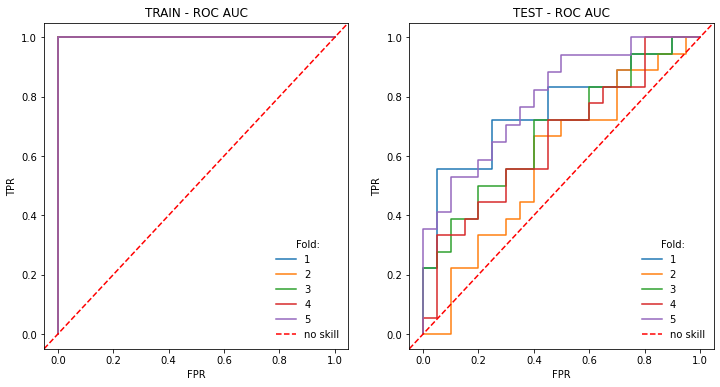

In [16]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=0)
fold = 1

train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}

param_grid = {'filter__k': np.linspace(10, 1000, 20, dtype=int),
              'logistic__C': 10**np.linspace(2, -3, 20)}
best_params = {'filter__k': [],
               'logistic__C': []}

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))

for train_index, test_index in cv.split(X, y):
       print(f"Working on fold {fold}")
       
       X_train, X_test = X.iloc[train_index], X.iloc[test_index]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]

       pipe = Pipeline([('scaler', StandardScaler()),
                        ('remove_constant', VarianceThreshold(threshold=0)),
                        ('filter', SelectKBest(f_classif)),
                        ('logistic', LogisticRegression(penalty='l1', random_state=0, solver='liblinear', max_iter=5000))])
       search = GridSearchCV(pipe, 
                             param_grid, 
                             n_jobs=4
                             #, error_score='raise'
                             )
       clf = search.fit(X_train, y_train)

       for param in search.best_params_.keys():
              best_params[param].append(search.best_params_[param])

       train_eval = evaluation(clf, X_train, y_train)
       train_metrics['accuracy'].append(train_eval[0])
       train_metrics['precision'].append(train_eval[1])
       train_metrics['recall'].append(train_eval[2])
       train_metrics['f1'].append(train_eval[3])
       train_metrics['ROC AUC'].append(train_eval[4])
       
       ax0.plot(train_eval[5], train_eval[6], label = str(fold))

       test_eval = evaluation(clf, X_test, y_test)
       test_metrics['accuracy'].append(test_eval[0])
       test_metrics['precision'].append(test_eval[1])
       test_metrics['recall'].append(test_eval[2])
       test_metrics['f1'].append(test_eval[3])
       test_metrics['ROC AUC'].append(test_eval[4])
       
       ax1.plot(test_eval[5], test_eval[6], label = str(fold))

       print(f"Train: \n{train_eval[7]}")
       print(f"Test: \n{test_eval[7]}")

       fold += 1

ax0.set(title= 'TRAIN - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
ax1.set(title= 'TEST - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
add_identity(ax0, color="r", ls="--",label = 'no skill')
add_identity(ax1, color="r", ls="--",label = 'no skill')
ax0.legend(frameon=False, loc='lower right', title='Fold:')
ax1.legend(frameon=False, loc='lower right', title='Fold:')

In [17]:
performance_train = pd.DataFrame(data=train_metrics, index=range(1, 6))
performance_train

,accuracy,precision,recall,f1,ROC AUC
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0


In [18]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_train[column].mean():.4f} ± {performance_train[column].std():.4f}")

Performance averaged over 5 folds:
accuracy = 1.0000 ± 0.0000
precision = 1.0000 ± 0.0000
recall = 1.0000 ± 0.0000
f1 = 1.0000 ± 0.0000
ROC AUC = 1.0000 ± 0.0000


In [19]:
best_params = pd.DataFrame(data=best_params, index=range(1,6))
best_params

,filter__k,logistic__C
1,7473,0.162378
2,6210,143.844989
3,2421,0.695193
4,3263,33.598183
5,2842,143.844989


In [20]:
performance_test = pd.DataFrame(data=test_metrics, index=range(1, 6))
performance_test

,accuracy,precision,recall,f1,ROC AUC
1,0.710526,0.705882,0.666667,0.685714,0.761111
2,0.578947,0.555556,0.555556,0.555556,0.586111
3,0.631579,0.590909,0.722222,0.650000,0.680556
4,0.631579,0.625000,0.555556,0.588235,0.655556
5,0.675676,0.631579,0.705882,0.666667,0.797059


In [21]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_test[column].mean():.4f} ± {performance_test[column].std():.4f}")

Performance averaged over 5 folds:
accuracy = 0.6457 ± 0.0499
precision = 0.6218 ± 0.0559
recall = 0.6412 ± 0.0807
f1 = 0.6292 ± 0.0551
ROC AUC = 0.6961 ± 0.0843


#### Historic performance of the model
param_grid = {'filter__k': np.linspace(100, 10000, 20, dtype=int),
              'logistic__C': 10**np.linspace(1, -8, 20)} 
|       | filter__k | logistic__C |
|-------|-----------|-------------|
| **1** | 100       | 0.379269    |
| **2** | 4789      | 10.000000   |
| **3** | 8957      | 3.359818    |
| **4** | 4268      | 0.379269    |
| **5** | 2184      | 10.000000   |

| Metric     | Value               |
|------------|---------------------|
| Accuracy   | 0.6300 ± 0.0461     |
| Precision  | 0.6047 ± 0.0392     |
| Recall     | 0.6190 ± 0.1236     |
| F1         | 0.6077 ± 0.0700     |
| ROC AUC    | 0.6575 ± 0.0974     |

param_grid = {'filter__k': np.linspace(2000, 10000, 20, dtype=int),
              'logistic__C': 10**np.linspace(3, -1, 20)}           
|       | filter__k | logistic__C |
|-------|-----------|-------------|
| **1** | 7473      | 0.162378    |
| **2** | 6210      | 143.844989  |
| **3** | 2421      | 0.695193    |
| **4** | 3263      | 33.598183   |
| **5** | 2842      | 143.844989  |

| Metric     | Value               |
|------------|---------------------|
| Accuracy   | 0.6457 ± 0.0499     |
| Precision  | 0.6218 ± 0.0559     |
| Recall     | 0.6412 ± 0.0807     |
| F1         | 0.6292 ± 0.0551     |
| ROC AUC    | 0.6961 ± 0.0843     |


### LR, Filter, RFE
Doesn't seem to be working in a reasonable time. 90+min runtime working on fold 1...

In [ ]:
from sklearn.feature_selection import RFE, mutual_info_classif

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=0)
fold = 1

train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}

param_grid = {'filter__k': np.linspace(20, 1000, 20, dtype=int),
              'logistic__C': 10**np.linspace(2, -3, 5)}
best_params = {'filter__k': [],
               'logistic__C': []}


fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))

for train_index, test_index in cv.split(X, y):
       print(f"Working on fold {fold}")
       
       X_train, X_test = X.iloc[train_index], X.iloc[test_index]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]

       pipe = Pipeline([('scaler', StandardScaler()),
                        ('remove_constant', VarianceThreshold(threshold=0)),
                        ('filter', SelectKBest(mutual_info_classif)),
                        ('logistic', LogisticRegression(penalty='l1', random_state=0, solver='liblinear', max_iter=5000))])
       search = GridSearchCV(pipe, 
                             param_grid, 
                             n_jobs=-1
                             #, error_score='raise'
                             )
       clf = search.fit(X_train, y_train)

       for param in search.best_params_.keys():
              best_params[param].append(search.best_params_[param])

       train_eval = evaluation(clf, X_train, y_train)
       train_metrics['accuracy'].append(train_eval[0])
       train_metrics['precision'].append(train_eval[1])
       train_metrics['recall'].append(train_eval[2])
       train_metrics['f1'].append(train_eval[3])
       train_metrics['ROC AUC'].append(train_eval[4])
       
       ax0.plot(train_eval[5], train_eval[6], label = str(fold))

       test_eval = evaluation(clf, X_test, y_test)
       test_metrics['accuracy'].append(test_eval[0])
       test_metrics['precision'].append(test_eval[1])
       test_metrics['recall'].append(test_eval[2])
       test_metrics['f1'].append(test_eval[3])
       test_metrics['ROC AUC'].append(test_eval[4])
       
       ax1.plot(test_eval[5], test_eval[6], label = str(fold))

       print(f"Train: \n{train_eval[7]}")
       print(f"Test: \n{test_eval[7]}")

       fold += 1

ax0.set(title= 'TRAIN - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
ax1.set(title= 'TEST - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
add_identity(ax0, color="r", ls="--",label = 'no skill')
add_identity(ax1, color="r", ls="--",label = 'no skill')
ax0.legend(frameon=False, loc='lower right', title='Fold:')
ax1.legend(frameon=False, loc='lower right', title='Fold:')

Working on fold 1
Train: 
[[80  0]
 [ 0 71]]
Test: 
[[17  3]
 [ 7 11]]
Working on fold 2


In [ ]:
performance_train = pd.DataFrame(data=train_metrics, index=range(1, 6))
performance_train

In [ ]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_train[column].mean():.4f} ± {performance_train[column].std():.4f}")

In [ ]:
param_grid

In [ ]:
best_params = pd.DataFrame(data=best_params, index=range(1,6))
best_params

In [ ]:
performance_test = pd.DataFrame(data=test_metrics, index=range(1, 6))
performance_test

In [ ]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_test[column].mean():.4f} ± {performance_test[column].std():.4f}")